In [1]:
!python --version

Python 3.8.8


## Required Libraries

In [2]:
import os
import numpy as np
from skimage.io import imread
from skimage.filters import threshold_otsu

from skimage import measure
from skimage.transform import resize
import matplotlib.patches as patches
import numpy as np

import joblib

from sklearn.decomposition import PCA

from sklearn.svm import SVC

import pickle

import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from operator import itemgetter

import zipfile
import matplotlib.pyplot as plt 


## Data Loading

In [3]:

training_20X20_dir = os.path.join('C:\\Users\\balha\\Desktop\\CISE-483-Final Report\\training_data', 'train20X20')
training_10X20_dir = os.path.join('C:\\Users\\balha\\Desktop\\CISE-483-Final Report\\training_data', 'train10X20')

letters = [
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D',
            'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T',
            'U', 'V', 'W', 'X', 'Y', 'Z'
        ]



In [4]:
image_data = []
target_data = []
for each_letter in letters:
    for each in range(10):
        #training_data[1] is for 10X20 training data images
        img_details = imread(training_20X20_dir+'/'+each_letter+'/'+each_letter+'_'+str(each)+'.jpg', as_gray=True)
        binary_image = img_details < threshold_otsu(img_details)
        flat_bin_image = binary_image.reshape(-1)
        image_data.append(flat_bin_image) 
        target_data.append(each_letter)

In [5]:
image_data, target_data = (np.array(image_data), np.array(target_data))

## Classifier Training

In [6]:
# kernel can be linear, rbf e.t.c
svc_model = SVC(kernel='linear', probability=True)

svc_model.fit(image_data, target_data)

SVC(kernel='linear', probability=True)

## Classifier Evaluation

In [7]:
wrong_predictions = True

img_train, img_test, target_train, target_test = train_test_split(image_data, target_data)
svc_model.fit(img_train, target_train)
prediction = svc_model.predict(img_test)
accuracy = (float(np.sum(prediction == target_test)) / len(target_test))

print(str(round(accuracy * 100, 2))+ "% accuracy was recorded")

def top_predictions(probabilities_prediction):
        predictions = probabilities_prediction.reshape(-1).tolist()
        predictions_label = []
        for index in range(len(predictions)):
            predictions_label.append((letters[index], predictions[index]))

        predictions_label = sorted(predictions_label, key=itemgetter(1), reverse=True)

        print(predictions_label[:5])

if wrong_predictions:
    print('Here are the wrong predictions')
    print('Prediction\tCorrect Label')
    print('------------------------------')

    for i in range(len(prediction)):
        if prediction[i] != target_test[i]:
            probabilities = svc_model.predict_proba(img_test[i].reshape(1, -1))
            print('Predicted: '+prediction[i]+'\t\t Actual:'+target_test[i])
            print('Probability Distribution')
            top_predictions(probabilities)
            print('------------------------')

    print('------------------------------')

    # self.print_wrong_predictions(prediction, target_test, img_test, model)

96.47% accuracy was recorded
Here are the wrong predictions
Prediction	Correct Label
------------------------------
Predicted: S		 Actual:5
Probability Distribution
[('6', 0.08615578879510388), ('S', 0.08318886760601675), ('5', 0.06921833291358623), ('9', 0.06463165167658755), ('G', 0.05470818645619777)]
------------------------
Predicted: Q		 Actual:0
Probability Distribution
[('Q', 0.25507024806860995), ('D', 0.12834068803084328), ('0', 0.09093275822515162), ('B', 0.05312946432810775), ('8', 0.04237492697663927)]
------------------------
Predicted: R		 Actual:B
Probability Distribution
[('R', 0.07388910683876068), ('B', 0.07279534185478173), ('D', 0.06038563796826763), ('E', 0.05016084270162111), ('G', 0.04715684978532382)]
------------------------
------------------------------


## Model Persistence

In [8]:
filename = "model.sav"
pickle.dump(svc_model, open(filename, 'wb'))
print("model saved")


model saved


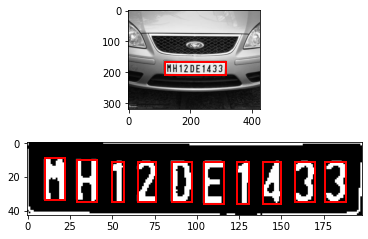

In [9]:
## Image Preparation
image_path = "test_image/car4.jpg"
car_image = imread(image_path, as_gray=True)*255
threshold_value = threshold_otsu(car_image)
binary_car_image = car_image > threshold_value
fig, (axis, axis1) = plt.subplots(2, 1)

## Detecting Plates
label_image = measure.label(binary_car_image)
image_height,  image_width=label_image.shape                  
plate_dim=(0.05*image_height,0.2*image_height,0.15*image_width,0.6*image_width)

## Plot car image
axis.imshow(car_image,cmap="gray")

lp_cands=[]
lp_cand_dimension=[]
for region in measure.regionprops(label_image):
    minRow, minCol, maxRow, maxCol = region.bbox
    (region_height,region_width)=(maxRow-minRow,maxCol-minCol)
    
    if(region.area < 50 or region_height<0.2*region_width ):
        continue
    candidate=np.invert(binary_car_image[minRow:maxRow,minCol:maxCol])
    if(region_height>=plate_dim[0] and region_height <=plate_dim[1] and region_width>=plate_dim[2] and region_width<= plate_dim[3]):

        r, c=candidate.shape
        if np.sum(candidate) > 0.3*r*c:
            continue
        
        rectBorder = patches.Rectangle((minCol, minRow), maxCol-minCol, maxRow-minRow, edgecolor="red", linewidth=2, fill=False)
        lp_cands.append(candidate)
        lp_cand_dimension.append(((minRow,minCol),(maxRow-minRow,maxCol-minCol)))
        
        # plotting.add_borders(rectBorder,fig,axis) 
        ## Add borders to license plate
        axis.add_patch(rectBorder)
    

## Character Segmentation
segmented_characters=[]
idx=0
for idx in range(len(lp_cands)):
    cand = lp_cands[idx]
    
    # plotting.plot_car_image(cand, fig, axis1)
    axis1.imshow(cand,cmap="gray")


    char_dim = (0.30*cand.shape[0], 0.90*cand.shape[0], 0.02*cand.shape[1], 0.1*cand.shape[1])
    
    labelled_cand = measure.label(cand)
    cnt=0
    border=[]
    temp_chars=[]
    for region in measure.regionprops(labelled_cand):                         
        minRow, minCol, maxRow, maxCol = region.bbox        
        (region_height,region_width)=(maxRow-minRow,maxCol-minCol)
        if(maxRow==lp_cand_dimension[idx][1][0]):
            continue
        #print(region_height,region_width)
        if(region_height>=char_dim[0] and region_height <=char_dim[1] and region_width>=char_dim[2] and region_width<= char_dim[3]):
            rectBorder = patches.Rectangle((minCol, minRow), maxCol-minCol, maxRow-minRow, edgecolor="red", linewidth=2, fill=False)
            border.append(rectBorder)
            temp_chars.append((minRow,maxRow,minCol,maxCol)) 
            
            # plotting.add_borders(rectBorder, fig, axis1)               
            axis1.add_patch(rectBorder)
    
    
    if(len(border)==10):               
        for borders in border:
            # plotting.add_borders(borders, fig, axis1)                    
            axis1.add_patch(borders)
    
        dim= lp_cand_dimension[idx]
        
        for val in temp_chars:
            r1=dim[0][0]+val[0]
            r2=dim[0][0]+val[1]
            c1=dim[0][1]+val[2]
            c2=dim[0][1]+val[3]
            segmented_characters.append((val[2],resize(np.invert(binary_car_image[r1:r2,c1:c2]),(20,20))))

## Show everything
plt.show()

## Inference

In [10]:
ans=[]
for char in segmented_characters:
    # print(plt.imshow(char[1]))
    ans.append(svc_model.predict(char[1].reshape(1,-1)))


license_plate= []
for val in ans:
    license_plate.append(val[0])

print("Detected License Plate Number:", "".join(license_plate))

Detected License Plate Number: MH1ZDE1433
